# Computer Vision

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Task 1

In [2]:
# модный widget загрузки
from google.colab import files

In [3]:
import numpy as np

import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from PIL import Image

Давай загрузим датасет CIFAR-10. Допиши функцию [load_dataloaders](./code-samples/cv_utils.py) с помощью [torchvision.datasets.CIFAR10](https://pytorch.org/vision/main/generated/torchvision.datasets.CIFAR10.html)
и [torch.utils.data.DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader), чтобы функция возвращала
DataLoaderы для train и test частей датасета. \
C помощью функции `len` количество батчей в train_loader и test_loader.
> Для DataLoader параметры `transform` и `batch_size` оставьте по умолчанию.

In [ ]:
BASE_TRANSFORM = transforms.Compose(
    [
        # Перевод изображений в тензоры
        transforms.ToTensor(),
        # Переводим цвета пикселей в отрезок [-1, 1]
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)
BATCH_SIZE = 64 # Количество изображений в Батче
CLASSES = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck') # Классы CIFAR10

In [ ]:
def load_dataloaders(transform=BASE_TRANSFORM, batch_size=BATCH_SIZE):
    # train set, 50k images
    train_set = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/School21/Day09/data', train=True, download=True, transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

    # test set, 10k images
    test_set = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/School21/Day09/data', train=False, download=False, transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

In [ ]:
train_dl, test_dl = load_dataloaders()

Files already downloaded and verified


In [ ]:
for IMG, label in train_dl:
  print(f"Shape of IMG [N, C, H, W]: {IMG.shape}")
  print(f"Shape of label: {label.shape} {label.dtype}")
  break
print(f'Рвазмер train_dl {len(train_dl)} батчей.\n')

for IMG, label in test_dl:
  print(f"Shape of IMG [N, C, H, W]: {IMG.shape}")
  print(f"Shape of label: {label.shape} {label.dtype}")
  break
print(f'Рвазмер test_dl {len(test_dl)} батчей.\n')

Shape of IMG [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of label: torch.Size([64]) torch.int64
Рвазмер train_dl 782 батчей.

Shape of IMG [N, C, H, W]: torch.Size([64, 3, 32, 32])
Shape of label: torch.Size([64]) torch.int64
Рвазмер test_dl 157 батчей.



## Task 2

Узнай, как из объекта DataLoader можно получить изображения и метки. \
Передай первые 4 изображения и метки из первого батча тестовой выборки в функцию [imshow](./code-samples/cv_utils.py).
С помощью нее можно визуализировать датасет. \
Должна получиться примерно такая визуализация.
![sample](../misc/images/images_sample.png)
> Картинки и метки могут отличаться. Главное чтобы метки сходились с изображениями)

In [ ]:
def imshow(images, labels, padding_size=15, labels_split_size=25):
    img = torchvision.utils.make_grid(images)
    # убрать нормализацию
    img = img / 2 + 0.5
    npimg = img.numpy()
    label_text = (' ' * labels_split_size).join('{}'.format(CLASSES[j]) for j in labels.tolist())
    #print(' ' * padding_size + label_text)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(label_text, fontdict={'fontsize':9}, loc='center')
    plt.axis("off")
    plt.show();

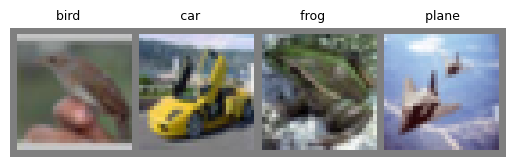

In [ ]:
dataiter = iter(train_dl)
images, labels = next(dataiter)

imshow(images[0:4],labels[0:4])

## Task 3

Теперь попробуем написать небольшую сверточную нейронную сеть, которую мы будем обучать классифицировать изображения.

Напишем сеть, основанную на одном блоке архитектуры [ResNet](https://arxiv.org/pdf/1512.03385.pdf) - Residual-Block. Схема этого блока приведена ниже:

<img src="../misc/images/rediual_block.png" width="500"/>

Допишите класс ResidualNet:
- Все сверточные слои должны иметь 32 выходных канала, а также не должны изменять ширину и высоту изображения.
- Также в сверточных слоях `padding = 1`

Функции, которые вам понадобяться:
[Conv2d](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html), [BatchNorm2d](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html), [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html).

Для базовой проверки, что сеть написана верно этот код не должен выдавать ошибку\
`assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)`

In [ ]:
from torch import nn

class ResidualNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()

        self.conv_3 = nn.Conv2d(3, 32, kernel_size=3, padding = 1)

        self.residual_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding = 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding = 1),
            nn.BatchNorm2d(32)
        )

        self.clf = nn.Sequential(
            nn.ReLU(),
            nn.AvgPool2d(8),
            nn.Flatten(1),
            nn.Linear(512, n_classes)
        )

    def forward(self, x):

        out = self.residual_block(x)
        out += self.conv_3(x)
        out = self.clf(out)

        return out

In [ ]:
net = ResidualNet()

assert net(torch.zeros((10, 3, 32, 32))).shape == (10, 10)

## Task 4

Перейдем к обучению сети. В этом вам поможет класс [Trainer](./code-samples/cv_utils.py).\
Для обучения кроме самой модели
требуемся определить оптимизатор и функцию ошибок:
* В качестве оптимизатора выберите [стохастический градиентный спуск](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html)
* В качестве функции ошибок
[кросс-энтропия](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)

Обучите сеть и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [ ]:
class Trainer:

    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.model = self.model.to(self.device)
        print('Сеть загружена на', self.device)

        self.optimizer = optimizer
        self.criterion = criterion

    def _train_epoch(self, train_loader):
        loss_log = []
        acc_log = []
        self.model.train()

        for data, target in train_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            self.optimizer.zero_grad()
            logits = self.model(data)

            loss = self.criterion(logits, target)
            loss.backward()
            self.optimizer.step()

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

    def train(self, train_loader, test_loader, n_epochs):

        self.train_loss_log = []
        self.train_acc_log = []
        self.test_loss_log = []
        self.test_acc_log = []

        for epoch in range(n_epochs):
            train_loss, train_acc = self._train_epoch(train_loader)
            test_loss, test_acc = self.test(test_loader)

            self.train_loss_log.append(train_loss)
            self.train_acc_log.append(train_acc)

            self.test_loss_log.append(test_loss)
            self.test_acc_log.append(test_acc)

            print(f"Epoch {epoch}")
            print(f" train loss: {np.mean(train_loss)}, train acc: {np.mean(train_acc)}")
            print(f" test loss: {test_loss}, test acc: {test_acc}\n")

    def test(self, test_loader):
        loss_log = []
        acc_log = []
        self.model.eval()

        for data, target in test_loader:
            data = data.to(self.device)
            target = target.to(self.device)

            with torch.no_grad():
                logits = self.model(data)
                loss = self.criterion(logits, target)

            loss_log.append(loss.item() * data.shape[0])

            acc = (logits.argmax(dim=1) == target).sum()
            acc_log.append(acc.item() / data.shape[0])

        return np.mean(loss_log), np.mean(acc_log)

In [ ]:
def plot_train_log(trainer):
    fig, axs = plt.subplots(1, 2, figsize=(13, 4))

    axs[0].plot(range(1, len(trainer.train_loss_log) + 1), trainer.train_loss_log, label='train')
    axs[0].plot(range(1, len(trainer.test_loss_log) + 1), trainer.test_loss_log, label='test')
    axs[0].set_ylabel('Loss')

    axs[1].plot(range(1, len(trainer.train_acc_log) + 1), trainer.train_acc_log, label='train')
    axs[1].plot(range(1, len(trainer.test_acc_log) + 1), trainer.test_acc_log, label='test')
    axs[1].set_ylabel('Accuracy')

    for ax in axs:
        ax.set_xlabel('Epoch')
        ax.legend()

    plt.show()

In [ ]:
model = ResidualNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=.01, momentum=.9)

Tr = Trainer(model,optimizer,loss_function)

Сеть загружена на cuda:0


In [ ]:
#%%time
Tr.train(train_dl, test_dl, 20)

Epoch 0
 train loss: 92.93388188647492, train acc: 0.47933983375959077
 test loss: 81.53671700787392, test acc: 0.5352308917197452

Epoch 1
 train loss: 74.17913655917663, train acc: 0.592451246803069
 test loss: 69.35522415987245, test acc: 0.618531050955414

Epoch 2
 train loss: 66.80529452955632, train acc: 0.6318134590792839
 test loss: 64.43477670706002, test acc: 0.6458996815286624

Epoch 3
 train loss: 61.961788003097105, train acc: 0.6635230179028133
 test loss: 62.8080306144277, test acc: 0.6605294585987261

Epoch 4
 train loss: 59.252051126621566, train acc: 0.6769900895140665
 test loss: 59.31080016360921, test acc: 0.6812300955414012

Epoch 5
 train loss: 56.93124468186323, train acc: 0.6896179667519181
 test loss: 59.96958547944476, test acc: 0.6643113057324841

Epoch 6
 train loss: 55.599392545802516, train acc: 0.7005474744245525
 test loss: 56.18414479152412, test acc: 0.6948646496815286

Epoch 7
 train loss: 54.033916385582344, train acc: 0.7055826406649617
 test loss:

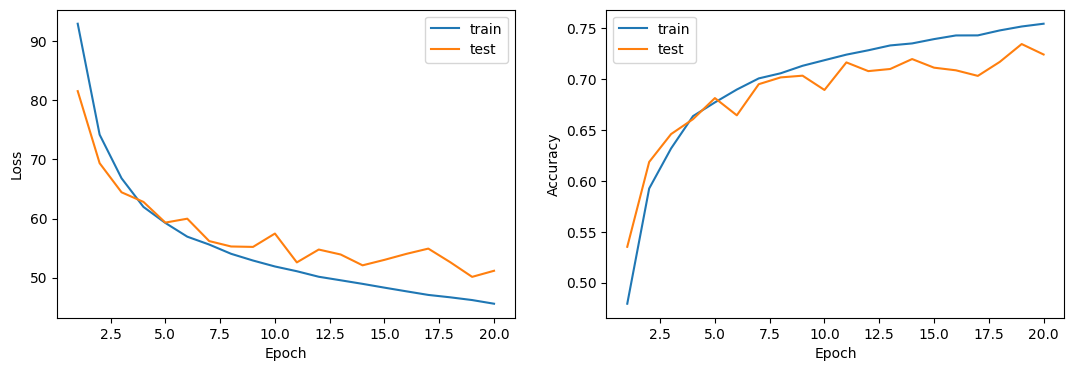

In [ ]:
plot_train_log(Tr)

In [ ]:
with torch.no_grad():
  torch.cuda.empty_cache()

## Task 5

Одной стандартной техникой, применяющейся в глубинном обучении, а особенно часто в компьютерном зрении, являются аугментации данных. \
Суть аугментаций состоит в том, что мы можем некоторым синтетическим образом видоизменять объекты обучающей выборки,  тем самым расширяя ее, а также делая итоговую модель более устойчивой к таким изменениям.
Наиболее удобным способом работы с аугментациями в PyTorch является их задание в списке `transforms`, который затем передается в Dataloader.\
Изучи, какие [способы аугментаций](https://pytorch.org/vision/main/auto_examples/plot_transforms.html#sphx-glr-auto-examples-plot-transforms-py)
изображений можно использовать PyTorch. Выберите несколько из них и визуализируйте как изменился датасет.
![sample](../misc/images/images_sample.png)
![sample](../misc/images/augment.png)

Обучите сеть с аугментацией данных и с помощью функции [plot_train_log](./code-samples/cv_utils.py) визуализируй процесс обучения модели.

In [ ]:
transform_v2 = transforms.Compose(
        [
            transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ]
)

In [ ]:
def load_dataloaders_v2(transform=BASE_TRANSFORM, transform1=transform_v2 ,batch_size=BATCH_SIZE):
    # train set, base + augm
    train_set_base = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/School21/Day09/data', train=True, download=True, transform=transform)
    train_set_augm = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/School21/Day09/data', train=True, download=False, transform=transform1)
    train_set_full = train_set_base + train_set_augm
    train_loader = torch.utils.data.DataLoader(train_set_full, batch_size=batch_size, shuffle=True, num_workers=2)

    # test set, base + augm
    test_set_base = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/School21/Day09/data', train=False, download=False, transform=transform)
    test_set_augm = torchvision.datasets.CIFAR10(root='/content/drive/MyDrive/School21/Day09/data', train=False, download=False, transform=transform1)
    test_set_full = test_set_base + test_set_augm
    test_loader = torch.utils.data.DataLoader(test_set_full, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, test_loader

In [ ]:
train_dl_1, test_dl_1 = load_dataloaders_v2()

Files already downloaded and verified


In [ ]:
print(len(train_dl_1), len(test_dl_1))

1563 313


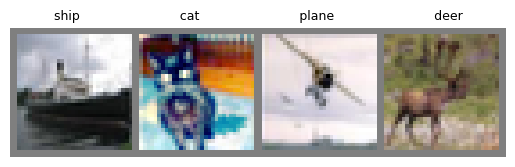

In [ ]:
dataiter = iter(train_dl_1)
images, labels = next(dataiter)

imshow(images[0:4],labels[0:4])

In [ ]:
model_1 = ResidualNet()
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_1.parameters(), lr=.01, momentum=.9)

Tr1 = Trainer(model_1,optimizer,loss_function)

Сеть загружена на cuda:0


In [ ]:
#%%time
Tr1.train(train_dl_1, test_dl_1, 20)

Epoch 0
 train loss: 95.48189354064903, train acc: 0.47448816378758796
 test loss: 83.9569560894951, test acc: 0.5379392971246006

Epoch 1
 train loss: 78.17120024887934, train acc: 0.5751159628918746
 test loss: 76.15288434013391, test acc: 0.5885583067092651

Epoch 2
 train loss: 72.76275790233453, train acc: 0.6075855726167626
 test loss: 71.91387817577812, test acc: 0.6089257188498403

Epoch 3
 train loss: 69.07257674858498, train acc: 0.6288187779910429
 test loss: 69.21329127790067, test acc: 0.6236521565495208

Epoch 4
 train loss: 66.70249200919768, train acc: 0.6407349648112604
 test loss: 69.47914657349023, test acc: 0.62689696485623

Epoch 5
 train loss: 65.118806205647, train acc: 0.651181621880998
 test loss: 66.79358515267174, test acc: 0.6441194089456869

Epoch 6
 train loss: 63.558086068219886, train acc: 0.6591890595009597
 test loss: 64.98335024800163, test acc: 0.6492611821086262

Epoch 7
 train loss: 62.13363070253066, train acc: 0.6662767914267435
 test loss: 65.73

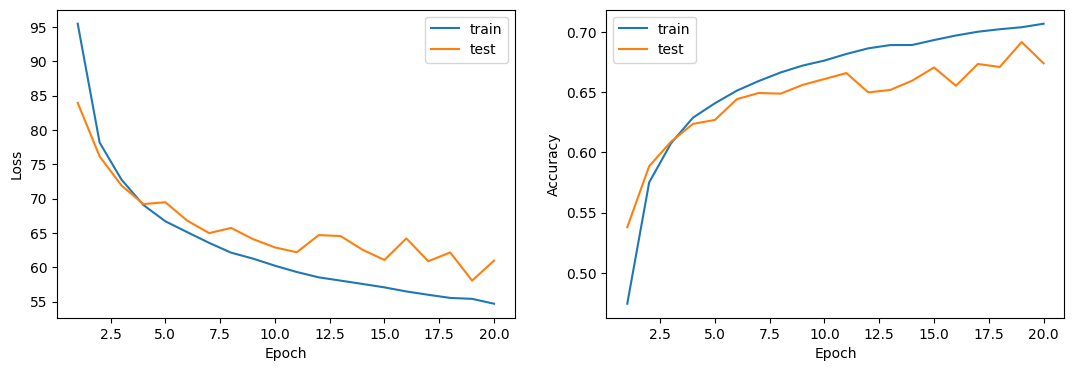

In [ ]:
plot_train_log(Tr1)

In [ ]:
with torch.no_grad(): # чистка кэша GPU
  torch.cuda.empty_cache()

# Дальше эксперименты

In [ ]:
# Сохраняем model
save_path = '/content/drive/MyDrive/School21/Day09/model.pth'
torch.save(model.state_dict(), save_path)

In [ ]:
# Сохраняем model_1
save_path_1 = '/content/drive/MyDrive/School21/Day09/model_1.pth'
torch.save(model_1.state_dict(), save_path_1)

In [ ]:
# Загружаем model
save_path = '/content/drive/MyDrive/School21/Day09/model.pth'

model = ResidualNet()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model.load_state_dict(torch.load(save_path, map_location=torch.device(DEVICE)))

model.eval()

In [ ]:
# Загружаем model_1
save_path_1 = '/content/drive/MyDrive/School21/Day09/model_1.pth'

model_1 = ResidualNet()

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
model_1.load_state_dict(torch.load(save_path_1, map_location=torch.device(DEVICE)))

model_1.eval()

In [ ]:
def test_nn (img_path, model_name, model_classes, model_transform): # Тестим сетки
      img = Image.open(img_path)

      img = img.resize((32,32))           # Меняем размер картинки т.к. обучалась сеть на 32х32
      plt.figure(figsize=(1,1))
      plt.axis("off")
      plt.imshow(img);
      input = model_transform(img)        # т.к. в трансформациях нет приведение размера
      input = input.unsqueeze(0)          # добавляем размерность тензора (как у батча)

      DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
      model_name.eval()                   # Модель в режим валидации
      with torch.no_grad():
        out = model_name(input.to(DEVICE))

      out_vec = out.cpu().numpy()
      idx = np.argmax(out_vec)
      plt.title(model_classes[idx], fontdict={'fontsize':9}, loc='center')
      #return model_classes[idx]

In [ ]:
!wget https://avatars.mds.yandex.net/i?id=dec210eb16ef44af295ca7a3f865902b-4078171-images-thumbs&n=13

--2023-06-28 15:10:56--  https://avatars.mds.yandex.net/i?id=dec210eb16ef44af295ca7a3f865902b-4078171-images-thumbs
Resolving avatars.mds.yandex.net (avatars.mds.yandex.net)... 87.250.247.182, 87.250.247.183, 87.250.247.184, ...
Connecting to avatars.mds.yandex.net (avatars.mds.yandex.net)|87.250.247.182|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3766 (3.7K) [image/jpeg]
Saving to: ‘i?id=dec210eb16ef44af295ca7a3f865902b-4078171-images-thumbs’

i?id=dec210eb16ef44 100%[===================>]   3.68K  --.-KB/s    in 0s      

2023-06-28 15:10:57 (937 MB/s) - ‘i?id=dec210eb16ef44af295ca7a3f865902b-4078171-images-thumbs’ saved [3766/3766]



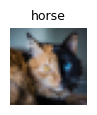

In [ ]:
test_nn(img_path="/content/cat.jpg", model_name = model, model_classes = CLASSES, model_transform = BASE_TRANSFORM)

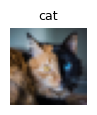

In [ ]:
test_nn(img_path="/content/cat.jpg", model_name = model_1, model_classes = CLASSES, model_transform = transform_v2)